# ICM cathode analysis - new material NCA

In this notebook, we employ ICM to infer the diffusivity of a NCA cathode.

The synthetic datasets generated with a pseudo-2D model via the Dandeliion solver:
- A classical [GITT pulse-relaxation experiment](https://simulation.dandeliion.com/legacy/simulation/?id=5a34af9f-782c-4c71-a38a-7c1ee86f3b83), used to infer $D_{\rm GITT}$ and $U_{\rm eq}^{\rm GITT}$.
- [Galvanostatic charge followed by discharge](https://simulation.dandeliion.com/legacy/simulation/?id=cef469da-e65f-45ce-bb09-7e7f9ce16561) at $C/20$, used to infer $U_{\rm eq}^{\rm pOCV}$.
- [Galvanostatic charge](https://simulation.dandeliion.com/legacy/simulation/?id=441bab43-d95a-453b-b225-a2858541f232) at $C/10$, used to infer $D_{\rm ICM}$.

All datasets share the same half-cell anode parameterisation but differ in their current protocols.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import InterpolatedUnivariateSpline

from fetch_Dandeliion import fetch_dandeliion
from GITT import apply_GITT
import ICM

## Loading simulation data

In [4]:
# simulation urls:
sim_urls = ['5a34af9f-782c-4c71-a38a-7c1ee86f3b83',
            'cef469da-e65f-45ce-bb09-7e7f9ce16561',
            '441bab43-d95a-453b-b225-a2858541f232',
           ]
sim_labels = ['NCA_GITT',
              'NCA_pOCV',
              'NCA_01C']

url_prefix = 'https://simulation.dandeliion.com/legacy/simulation/?id='

simulation_save_dir = 'Dandeliion_Simulations'
inference_save_dir = 'inference_data'

GITT_tag = sim_labels[0]
pOCV_tag = sim_labels[1]
data_tag = sim_labels[2]

sims = dict()
for url, label in zip(sim_urls, sim_labels):
    save_path=os.path.join(simulation_save_dir, label)
    sims[label] = fetch_dandeliion(url_prefix+url, label, simulation_save_dir)

Simulation NCA_GITT already in Dandeliion_Simulations. Using local copy.
Simulation NCA_pOCV already in Dandeliion_Simulations. Using local copy.
Simulation NCA_01C already in Dandeliion_Simulations. Using local copy.


First, let's collect battery parameters, some of which are common across all three simulations. We'll do this only once|

In [6]:
# Take the ground truth D(x) and Ueq(x) for the anode:
D_ref, Ueq_ref= [sims[pOCV_tag][key] for key in ['D_c', 'Ueq_c']]

U_counter = sims[pOCV_tag]['Ueq_a'] # This is zero anyway, so can safely ignore

F = 96485.3321 # Faraday's constant [C/mol]

A_electrode = sims[pOCV_tag]['A'][1] # surface area of electrode [m^2]
L_electrode = sims[pOCV_tag]['L'][1] # thickness of electrode [m]
R_particle = sims[pOCV_tag]['R'][1] # Particle radius [m]
epsilon = sims[pOCV_tag]['el'][1] # volume fraction of electrolyte
bet = sims[pOCV_tag]['bet'][1] # active surface area per unit volume [1/m]
cmax = sims[pOCV_tag]['cmax'][1] # maximum concentration [mol/m^3]

V_electrode = A_electrode * L_electrode # m^3
V_particle = 4.*np.pi/3 * R_particle**3 # m^3
Np = (1 - epsilon) * V_electrode / V_particle # Number of active particles, estimated
S_contact = bet * V_electrode # m^2
S_particle = 4*np.pi*R_particle**2 # Particle surface area [m^2]

In [7]:
# Initial concentrations are different in the runs:
print([sims[key]['cs0'][1] for key in sims.keys()])
c0_pOCV = sims[pOCV_tag]['cs0'][1]
c0_data = sims[data_tag]['cs0'][1]

# Initial stoichiometry [or dimensionless concentration] 
x0_pOCV = c0_pOCV/cmax 
x0 = c0_data/cmax # same for GITT and C/10 galvanostatic charge

[36635.0, 38790.0, 36635.0]


## Inferring diffusivity from GITT data using Sand equation

We start by applying the Sand Equation formula to GITT simulation and infer diffusivity $D_{\rm GITT}(c)$.

Let us first extract the time, current and voltage data.

In [9]:
t_GITT, I_GITT, V_GITT, I_sub_GITT = [sims[GITT_tag][key] for key in ['t_data', 'I_data', 'V_data', 'I_sub']]

Now, since we are dealing with a GITT pulse/relaxation data, we need to determine the indices at which there is a switch/on -- switch/off.

The data was cut-off at V=4.2 V, so the last point is part of a non-zero current (kick). We will not use the kick, but will still use the preceding off-state to infer the equilibrium potential.

In [11]:
idx_nonzero = np.where(I_GITT !=0)[0][:-1] # points where I != 0
idx_zero = np.where(I_GITT ==0)[0] # points where I = 0

# points where I=0 switched to I != 0 
idx_on = np.r_[1,idx_nonzero[np.where(np.diff(idx_nonzero) !=1)[0]+1]]

# and points where I !=0 switched to I=0
idx_off = idx_zero[np.where(np.diff(idx_zero) !=1)[0]+1]

# Combine all switches, on and off
idx_switch = np.sort(np.r_[idx_on, idx_off])

# The final index, as the data ends when current is on
idx_end = idx_on[-1]

We now compute the average stoichiometry at each time point by integrating the input current over time, assuming uniform distribution of lithium across all active particles in the electrode via charge conservation. For this, we use the current time series submitted to the Dandeliion simulation, since the recorded currents may omit the exact onset or offset of pulse and relaxation periods, potentially leading to under- or overestimation of the transferred charge.

In [19]:
# total accumulated charge at each time grid point in the submitted current:
Q_sub_GITT = np.cumsum( np.r_[0,(I_sub_GITT[1,1:] + I_sub_GITT[1,:-1])*np.diff(I_sub_GITT[0])/2] )

# accumulated charge, at time values t_SI, obtained by interpolating the above:
Q_GITT = np.interp(t_GITT, I_sub_GITT[0], Q_sub_GITT)

# Assume the charge is uniformly distributed at each cathode particle. Then the stoichiometries:
x_GITT = (x0 - Q_GITT/F/Np/V_particle/cmax)

### Inferring OCV from GITT data
We will take the stoichiometry and potential values evaluated at the offset of each relaxation period, which ensures they are closest to equilibrium.

In [21]:
# OCV from GITT:
x_eq_GITT = x_GITT[idx_on-1] # stoichiometries at the offset of the relaxation phases
V_eq_GITT = V_GITT[idx_on-1] # Potentials at the offset of the relaxation phases

### Inferring diffusivity
The returned values correspond to `x_eq_GITT[:-1]` (excluding the final point which lacks pulse information).

In [23]:
D_GITT, *_ = apply_GITT(t_GITT, I_GITT, V_GITT, R_particle, idx_on, idx_off, I_threshold=0.01)

### Comparison to ground truth

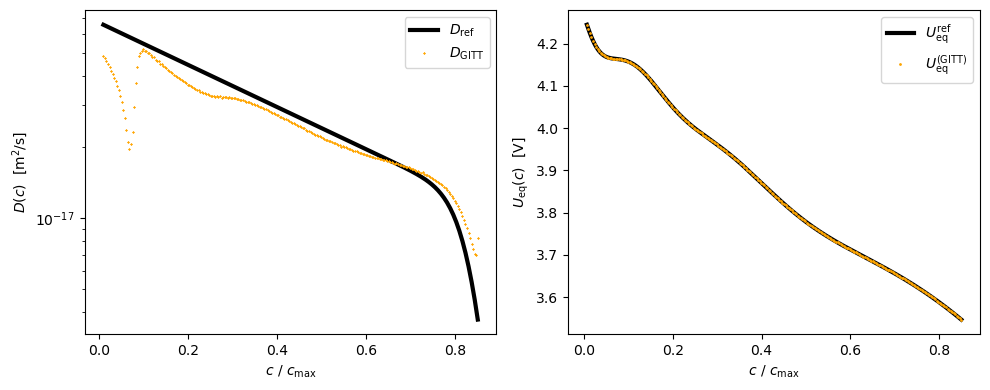

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_eq_GITT[:-1], D_ref(x_eq_GITT[:-1]), 'k', lw=3, label=r"$D_{\rm ref}$")
plt.plot(x_eq_GITT[:-1], D_GITT, 'x', markersize=1, markeredgecolor='orange', label=r"$D_{\rm GITT}$")
plt.legend()
plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c)~~\mathrm{[m^2/s]}$")
plt.subplot(1,2,2)
plt.plot(x_eq_GITT, Ueq_ref(x_eq_GITT), 'k', lw=3, label=r"$U_{\rm eq}^{\rm ref}$")
plt.plot(x_eq_GITT, V_eq_GITT, 'o', markersize=1, markeredgecolor='orange', label=r"$U_{\rm eq}^{\rm (GITT)}$")
plt.legend()
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$U_{\rm eq}(c)~~\mathrm{[V]}$")
plt.tight_layout()
plt.show()

## Inferring diffusivity with ICM approach

Unlike GITT, two datasets are required to infer diffusivity with ICM: a slow dataset to determine the open-circuit voltage, and a separate dataset for the diffusivity inference.

### Inferring $U_{\rm eq}$ from pOCV data
The $C/20$ galvanostatic protocol is sufficiently slow to minimise overpotentials. In addition, we combine charge and discharge data to cancel any residual overpotential effects.

In [28]:
# Take the time, current and voltage data. Note the two current data (see below)
t_pOCV, I_pOCV, V_pOCV = [sims[pOCV_tag][key] for key in ['t_data', 'I_data', 'V_data']]

In [29]:
# total accumulated charge at each time grid point in the submitted current:
Q_pOCV = np.cumsum( np.r_[0,(I_pOCV[1:] + I_pOCV[:-1])*np.diff(t_pOCV)/2] )

# Assume the charge is uniformly distributed at each cathode particle. Then the stoichiometries:
x_pOCV = (x0_pOCV - Q_pOCV/F/Np/V_particle/cmax)

# Turning point from charge to discharge
idx_turn = np.argmin(x_pOCV)

V_pOCV_charge = V_pOCV[:idx_turn+1] - U_counter(0.)
x_pOCV_charge = x_pOCV[:idx_turn+1]

V_pOCV_discharge = V_pOCV[idx_turn:] - U_counter(0.)
x_pOCV_discharge = x_pOCV[idx_turn:]

# Interpolate charge/discharge voltages
V_pOCV_charge_int = lambda x: np.interp(x, x_pOCV_charge[::-1], V_pOCV_charge[::-1])
V_pOCV_discharge_int = lambda x: np.interp(x, x_pOCV_discharge, V_pOCV_discharge)


In [30]:
# Add them up by interpolating in the common stoichiometry domain.
x_pOCV_min = max(min(x_pOCV_charge), min(x_pOCV_discharge))
x_pOCV_max = min(max(x_pOCV_charge), max(x_pOCV_discharge))
x_pOCV_range = np.linspace(x_pOCV_min, x_pOCV_max, 1000)
Ueq_pOCV = InterpolatedUnivariateSpline(x_pOCV_range, 
                                        0.5*(V_pOCV_charge_int(x_pOCV_range) + V_pOCV_discharge_int(x_pOCV_range)), 
                                        k=1)

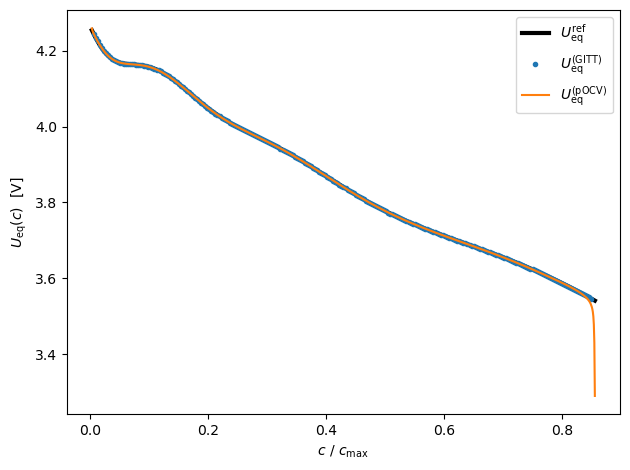

In [31]:
plt.plot(x_pOCV_range, Ueq_ref(x_pOCV_range), 'k', lw=3, label=r"$U_{\rm eq}^{\rm ref}$")
plt.plot(x_eq_GITT, V_eq_GITT, 'o', markersize=3,  label=r"$U_{\rm eq}^{\rm (GITT)}$")
plt.plot(x_pOCV_range, Ueq_pOCV(x_pOCV_range), label=r"$U_{\rm eq}^{\rm (pOCV)}$")
plt.legend()
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$U_{\rm eq}(c)~~\mathrm{[V]}$")
plt.tight_layout()
plt.show()

This is the regime of validity of the OCV that we infer here.

In [33]:
x_pOCV_min, x_pOCV_max

(np.float64(0.003373258004295665), np.float64(0.8557661944012467))

### Inferring diffusivity
We use the $C/10$ galvanostatic charging data to infer diffusivity.

In [35]:
# Take the time, current and voltage data in SI units
t_SI, I_SI, V_SI = [sims[data_tag][key] for key in ['t_data', 'I_data', 'V_data']]

# total accumulated charge at each time grid point in the submitted current:
Q_SI = np.cumsum( np.r_[0,(I_SI[1:] + I_SI[:-1])*np.diff(t_SI)/2] )
# Assume the charge is uniformly distributed at each cathode particle. Then the stoichiometries:
x_SI = (x0 - Q_SI/F/Np/V_particle/cmax)

In [46]:
# Code units in SI 
r_unit = R_particle 
D_unit = 1e-15 
t_unit = r_unit**2 / D_unit 
c_unit = cmax 
I_unit = F * c_unit* D_unit * r_unit  # A 
j_unit = I_unit / r_unit**2 /F   # mol/m^2/s 
V_unit = 1  # [V]  

# Dandeliion data in code units: 
V_data = (V_SI- U_counter(0.))/V_unit 
t_data = t_SI/t_unit 
# Plus sign corresponds to cathode.
j_data = I_SI / Np / S_particle / F / j_unit # use this only if necessary  

j_int = InterpolatedUnivariateSpline(t_data, j_data, k=1)  

#### Partitioning the data

In [49]:
N_partition = 50
idx_parts, t_parts, j_parts, V_parts = ICM.partition_data(N_partition, t_data, j_data, V_data)

Visualising the partitions

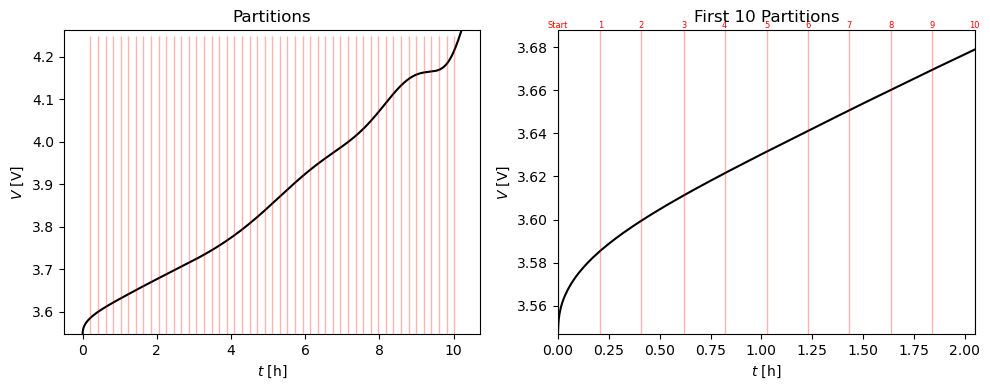

In [52]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
part_max = 10
plt.plot(t_SI/3600,  V_SI, 'k-')
plt.vlines(t_SI[idx_parts[1:-1]]/3600, 2.50, 4.25, color='r', lw=1, alpha=0.3)
plt.xlabel(r"$t$ [h]")
plt.ylabel(r"$V$ [V]")


plt.ylim([min(V_SI), max(V_SI)])

plt.title("Partitions")

plt.subplot(1,2,2)
plt.title(f"First {part_max} Partitions")
plt.plot(t_SI/3600, V_SI, 'k-')
# Add counters for each line

Vrange = np.hstack( V_parts[:part_max+1]) - U_counter(0.)
Vmin, Vmax = np.min(Vrange), np.max(Vrange)

plt.vlines(t_SI[idx_parts[:-1]]/3600, Vmin, Vmax, color='r', lw=1, alpha=0.3)

for i, x in enumerate(t_SI[idx_parts[1:part_max+1]]/3600):
    plt.text(x, Vmax, str(i + 1), color='r', ha='center', va='bottom',fontsize='6')

plt.text(t_SI[idx_parts[0]]/3600, Vmax, "Start", color='r', ha='center', va='bottom',fontsize='6')

plt.xlabel(r"$t$ [h]")
plt.ylabel(r"$V$ [V]")
plt.xlim([0,t_parts[part_max][0]*t_unit/3600])
plt.ylim([Vmin, Vmax])
plt.tight_layout()
plt.show()

#### Optimisation stage 1: Local optimisation

We now begin with the first approximation, which assumes constant diffusivity within each partition, corresponding to the partition's average concentration.

__Note about adaptive solvers__: One must ensure that important features in the data are not missed due to excessively large time steps taken by the ODE solver. This is controlled via the `dt_max` parameter. It is particularly relevant for drive-cycle or GITT data, where abrupt changes may occur within a very short timescale. In general, for efficiency, `dt_max` should be provided separately for each partition. However, for galvanostatic data, we set a common `dt_max` based on the partition duration to prevent the solver from stepping across partition boundaries during integration.

In [56]:
dt_max_global = (t_data[-1]- t_data[0])/N_partition
dt_max_parts = dt_max_global*np.ones(N_partition)

In [60]:
%%time 
c_knots, D_knots_pass1, mse_pass1, cini_pass1 = ICM.local_optimisation(x0, t_parts, j_parts, V_parts, j_int, dt_max_parts, Ueq_pOCV)

No minimum found at partition #0.
Widening the search to [-3, 3] with 100 points...
Success!
No minimum found at partition #1.
Widening the search to [-3, 3] with 100 points...
Success!
No minimum found at partition #2.
Widening the search to [-3, 3] with 100 points...
Success!
No minimum found at partition #3.
Widening the search to [-3, 3] with 100 points...
Success!
No minimum found at partition #4.
Widening the search to [-3, 3] with 100 points...
Success!
concentration outside [0,1]
concentration outside [0,1]
concentration outside [0,1]
concentration outside [0,1]
concentration outside [0,1]
CPU times: user 12.1 s, sys: 1.64 s, total: 13.7 s
Wall time: 11.3 s


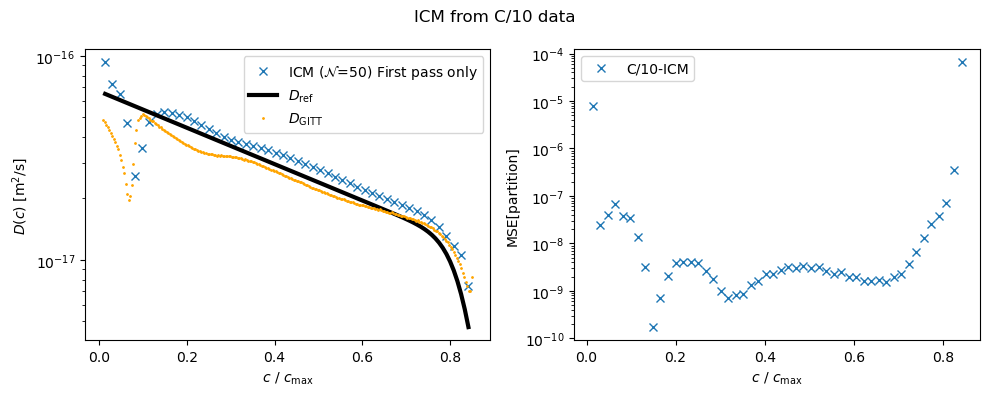

In [62]:
c_values = np.linspace(min(c_knots), max(c_knots),100)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(c_knots, D_knots_pass1*D_unit, 'x', label=r"ICM ($\mathcal{{N}}$={}) First pass only".format(N_partition))
plt.plot(c_values,  D_ref(c_values), 'k', lw=3, label=r"$D_{\rm ref}$")
plt.plot(x_eq_GITT[:-1], D_GITT, 'o', markersize=1, markeredgecolor='orange', label=r"$D_{\rm GITT}$")

plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
plt.legend()

plt.subplot(1,2,2)
plt.plot(c_knots, mse_pass1, 'x',label="C/10-ICM")
plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel("MSE[partition]")
plt.suptitle("ICM from C/10 data")
plt.legend()
plt.tight_layout()
plt.show()

#### Gradient Descent

Now for each $\theta_i = \log_{10}D(c_i) - \log_{10}D_{\rm unit}$, we evaluate the **global** loss at $\bar\theta_i\pm\delta \theta$ to estimate
$$
\frac{\partial \mathcal{L}}{\partial \theta_i}\Bigg\vert_{\theta_i=\bar\theta_i} \approx \frac{\mathcal{L}(\bar\theta_i+\delta\theta)- \mathcal{L}(\bar\theta_i-\delta\theta)}{2\,\delta\theta}\,.
$$
This gives us a numerical estimate of the (negative) direction for the gradient descent. Then, for learning rate $\eta$, we define the new parameter:
$$
\tilde{\theta}_i = \bar\theta_i - \eta\,\frac{\partial \mathcal{L}}{\partial \theta_i}\Bigg\vert_{\theta_i=\bar\theta_i}\,.
$$

In [65]:
%%time 
D_knots_best, D_knots_all, R2_all = ICM.gradient_descent(c_knots, D_knots_pass1, Ueq_pOCV, x0, j_int, t_data, V_data, x_SI, dt_max_global, eta_ini = 5000, eta_decay = .99, eta_decay_period = 2, N_iter_max = 100, dtheta =1e-4)

32 CPU cores detected, using all available cores for gradient calculation.


CPU times: user 11.2 s, sys: 2.1 s, total: 13.3 s
Wall time: 1min 18s


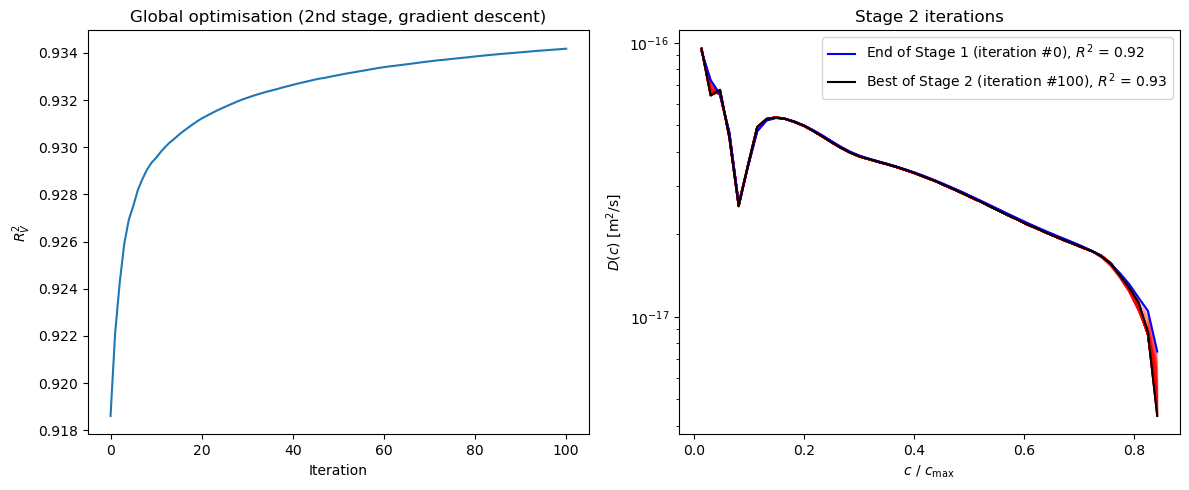

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R2_all)
plt.xlabel("Iteration")
plt.ylabel(r"$R^2_V$")
plt.title("Global optimisation (2nd stage, gradient descent)")

plt.subplot(1,2,2)
for i, DD in enumerate(D_knots_all):
    plt.plot(c_knots, DD*D_unit, 'r', alpha = 0.2)
plt.plot(c_knots, D_knots_pass1*D_unit, 'b', label= r"End of Stage 1 (iteration #0), $R^2$ = {:.2f}".format(R2_all[0]))
plt.plot(c_knots, D_knots_best*D_unit, 'k', label = r"Best of Stage 2 (iteration #{}), $R^2$ = {:.2f}".format(np.argmax(R2_all),np.max(R2_all)))

plt.yscale("log")
plt.legend()
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
plt.title("Stage 2 iterations")
plt.tight_layout()
plt.show()

## Comparisons

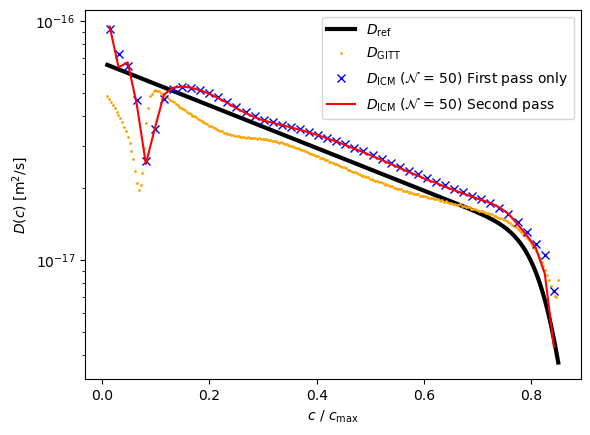

In [68]:
plt.plot(x_eq_GITT[:-1],  D_ref(x_eq_GITT[:-1]), 'k', lw=3, label=r"$D_{\rm ref}$")
plt.plot(x_eq_GITT[:-1], D_GITT, 'o', markersize=1, markeredgecolor='orange', label=r"$D_{\rm GITT}$")
plt.plot(c_knots, D_knots_pass1*D_unit, 'x', markeredgecolor='b', label=r"$D_{{\rm ICM}}$ ($\mathcal{{N}}$ = {}) First pass only".format(N_partition))
plt.plot(c_knots, D_knots_best*D_unit, 'r', label=r"$D_{{\rm ICM}}$ ($\mathcal{{N}}$ = {}) Second pass".format(N_partition))

plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
plt.legend()
plt.show()


In [69]:
# Interpolated diffusivity functions:

D_GITT_int = InterpolatedUnivariateSpline(x_eq_GITT[-2::-1], D_GITT[::-1], k=1, ext=3)
D_ICM_pass1_int = InterpolatedUnivariateSpline(c_knots[::-1], D_knots_pass1[::-1]*D_unit, k=1, ext=3)
D_ICM_pass2_int = InterpolatedUnivariateSpline(c_knots[::-1], D_knots_best[::-1]*D_unit, k=1, ext=3)


We now compute the $R^2_D$ measure. Since the concentration domains for the two methods differ slightly, we restrict the comparison to their common domain for a fair comparison:
$$
R^2_D(D) = 1 - \frac{\left\langle (D(c)- D_{\rm ref}(c))^2\right\rangle_c}{\left\langle (D_{\rm ref}(c)- \langle D_{\rm ref}(c)\rangle_c)^2\right\rangle_c}\,.
$$
Here, $\langle \cdot \rangle_c$ denotes averaging over the common concentration domain.

In [71]:
# min and max of common domain
c_min = max(min(x_eq_GITT[:-1]), min(c_knots))
c_max = min(max(x_eq_GITT[:-1]),max(c_knots))

In [72]:
from scipy.integrate import quad

D_ref_av = quad(D_ref, c_min, c_max)[0]/(c_max-c_min)
D_ref_var = quad(lambda x: (D_ref(x) - D_ref_av)**2, c_min, c_max)[0]/(c_max-c_min)

R2D_GITT = 1- quad(lambda x: (D_GITT_int(x)- D_ref(x))**2, c_min, c_max)[0]/(c_max-c_min)/D_ref_var
R2D_ICM_pass1 = 1- quad(lambda x: (D_ICM_pass1_int(x)- D_ref(x))**2, c_min, c_max)[0]/(c_max-c_min)/D_ref_var
R2D_ICM_pass2 = 1- quad(lambda x: (D_ICM_pass2_int(x)- D_ref(x))**2, c_min, c_max)[0]/(c_max-c_min)/D_ref_var
print("R^2_D values")
print("         GITT: {:.3f}".format(R2D_GITT))
print("ICM [stage 1]: {:.3f}".format(R2D_ICM_pass1))
print("ICM [stage 2]: {:.3f}".format(R2D_ICM_pass2))

R^2_D values
         GITT: 0.681
ICM [stage 1]: 0.791
ICM [stage 2]: 0.803


Note that the concentration range for ICM is smaller than GITT, so these values essentially use the range for ICM. Let's see how unfair it is for GITT, by re-evaluating the R^2_D measure for GITT's own range of concentrations. Some mild improvement, nothing dramatic.

In [80]:
c_min_GITT, c_max_GITT = min(x_eq_GITT[:-1]), max(x_eq_GITT[:-1])
D_ref_av = quad(D_ref, c_min_GITT, c_max_GITT)[0]/(c_max_GITT-c_min_GITT)
D_ref_var = quad(lambda x: (D_ref(x) - D_ref_av)**2, c_min_GITT, c_max_GITT)[0]/(c_max_GITT-c_min_GITT)
R2D_GITT_alt = 1- quad(lambda x: (D_GITT_int(x)- D_ref(x))**2, c_min_GITT, c_max_GITT)[0]/(c_max_GITT-c_min_GITT)/D_ref_var

print("R^2_D values [using GITT's own range]")
print("         GITT: {:.3f}".format(R2D_GITT_alt))

R^2_D values [using GITT's own range]
         GITT: 0.672


It's actually slightly worse.

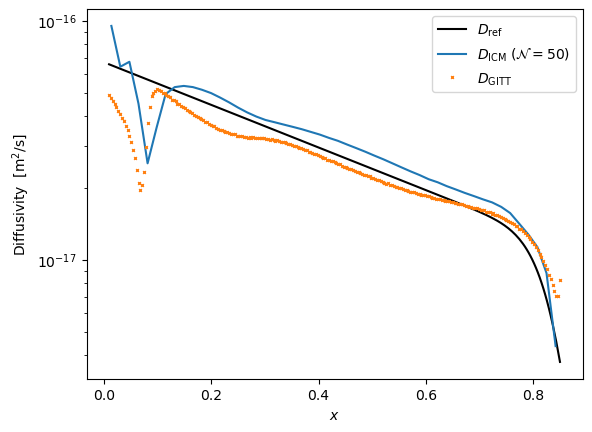

In [156]:
plt.plot(x_eq_GITT[:-1],  D_ref(x_eq_GITT[:-1]), 'k',  label = r"$D_{\rm ref}$")
plt.plot(c_knots, D_knots_best*D_unit, label=r"$D_{{\rm {}}}$ ($\mathcal{{N}}=50$)".format("ICM"))

plt.plot(x_eq_GITT[:-1], D_GITT, 'x', markersize=2,label = r"$D_{\rm GITT}$")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"Diffusivity $\mathrm{~[m^2/s]}$")
# plt.savefig("fig_DFN_comparison_NCA.pdf")
plt.show()

## The spike in the diffusivity
Comparing the inferred model with the null model, the SPM analogue of the reference model and data.

In [83]:
# Inferred diffusivity 
D_inferred_int =  InterpolatedUnivariateSpline(c_knots[::-1], D_knots_best[::-1], k=1, ext= 3)
D_inferred_prime_int =  D_inferred_int.derivative()

# Reference diffusivity at the knots
D_ref_int =  InterpolatedUnivariateSpline(c_knots[::-1], D_ref(c_knots[::-1])/D_unit, k=1, ext= 3)
D_ref_prime_int =  D_ref_int.derivative()

# Simple SPM evolution
N=50
M_inv = ICM.calc_mass_inv(N, 1)
r_grid = np.linspace(0,1,N)
r2mid = 0.25*(r_grid[1:] + r_grid[:-1])**2
dr = r_grid[1]-r_grid[0]
sol_inferred = ICM.predict(D_inferred_int, D_inferred_prime_int, j_int, t_data, x0* np.ones(N), N, dr, M_inv, r2mid, rtol=1.e-5, atol=1.e-8, dt_max=None, events=False)
sol_ref = ICM.predict(D_ref_int, D_ref_prime_int, j_int, t_data, x0* np.ones(N), N, dr, M_inv, r2mid, rtol=1.e-5, atol=1.e-8, dt_max=None, events=False)

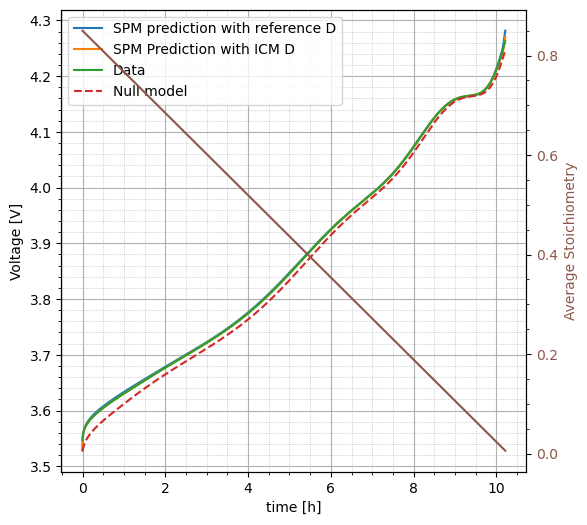

In [85]:
fig, ax1 = plt.subplots(figsize=(6, 6))

t_plot = t_data * t_unit / 3600

# --- Left axis: Voltage ---
ax1.grid(True)
ax1.plot(t_plot, Ueq_pOCV(sol_ref.y[-1]), label="SPM prediction with reference D")
ax1.plot(t_plot, Ueq_pOCV(sol_inferred.y[-1]), label="SPM Prediction with ICM D")
ax1.plot(t_plot, V_data, label="Data")
ax1.plot(t_plot, Ueq_pOCV(x_SI), label="Null model", ls="--")

ax1.set_xlabel("time [h]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(loc="upper left")

# --- Right axis: Stoichiometry ---
ax2 = ax1.twinx()
ax2.plot(t_plot, x_SI, color="tab:brown")
ax2.set_ylabel("Average Stoichiometry", color="tab:brown")
ax2.tick_params(axis="y", labelcolor="tab:brown")

ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which="minor", linestyle=":", linewidth=0.5)
plt.show()


The spike in the inferred diffusivity is due to the flat region around $x\in [0.05, 0.1]$. The output voltage of the model is very insensitive to the surface concentration, thus diffusivity, so even a small discrepancy is corrected with large steps in diffusivity.

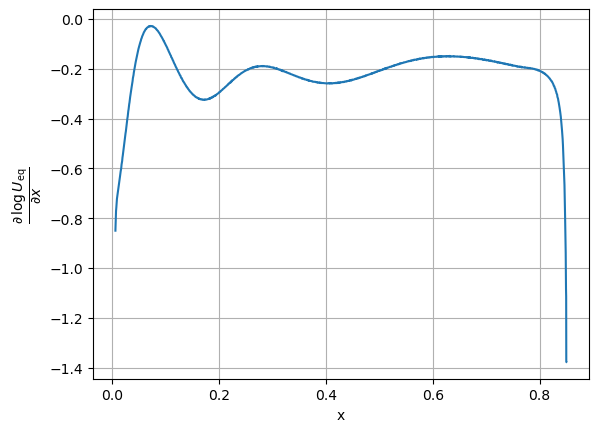

In [139]:
plt.plot(x_SI[:-1], np.diff(Ueq_pOCV(x_SI))/np.diff(x_SI)/Ueq_pOCV(x_SI)[:-1])
plt.grid("on")
plt.xlabel("x")
plt.ylabel(r"$\dfrac{\partial\, \log U_{\rm eq}}{\partial x}$")
plt.show()

The main issue is where the equilibrium potential plateaus and its derivative is negligible. The Weppner-Huggins formula also breaks down when this happens.